This code has been tested and proved functional on HPC ACCRE from Vanderbilt University. 

In [32]:
import os
cwd = os.getcwd()
print(cwd)

/panfs/accrepfs.vampire/home/dongz1/FluxCT-V2.0/batch_code


In [4]:
'''
This script allows the user to create the data products and plots from FluxCT for multiple targets without using the webtool. 

INPUTS: 
 --> The user will need to specify the directory path for code and plots. 
 --> An input table of either KIC IDs with the format 'id' as the column name and comma separators. 

OUTPUTS: 
 --> Downloaded fits file for the star from lightkurve to the plots directory. 
 --> Downloaded plot created by FluxCT to the plots directory. 
 --> Downloaded FluxCT data products to a .csv file.
'''

# Import modules
import time 
import pandas as pd  
from lightkurve import search_targetpixelfile
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.io import fits 
import numpy as np
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
import math
from ast import literal_eval
import ssl
import lightkurve
import os
import glob
import shutil
from matplotlib import patches



class MyTPF(object):
    """
    Basic TPF class to give interactions similar to Lightkurve TargetPixelFiles

    Attributes
        filename (str): path to source file
        flux (ndarray): 2D array of summed flux
        pipeline_mask (ndarray): 2D boolean array indicated aperture pixels
        wcs (astropy.wcs.WCS): world coordinate system from source file
    """
    def __init__(self, filename):
        """
        Read basic TPF information from a FITS file

        Parameters:
            filename (str): full path to FITS file
        """
        with fits.open(filename,memmap=False) as hdul: # notice memmap has to be False otherwise it triggers WinError 32 cannot access cuz other is also accessing
            self.filename = filename
            self.flux = hdul[2].data
            self.pipeline_mask = (hdul[3].data & 2).astype(bool)
            self.wcs = WCS(hdul[2])
            hdul.close()

    @property
    def shape(self):
        """Returns the (height, width) of the TPF.
        """
        return self.flux.shape
    
    def get_central_coordinate(self):
        """Returns an astropy.coordinates.SkyCoord object with the TPF central coordinates
        """
        h, w = self.shape
        return self.wcs.pixel_to_world(w//2, h//2)
    
    def plot(self, ax=None, aperture_mask="pipeline", mask_color="w", **kw):
        """
        Plot the TPF a la lightkurve.TargetPixelFile.plot

        Parameters
            ax (matplotlib axes object): axes to plot the TPF
            aperture_mask (str or ndarray): boolean array for aperture
            mask_color (str): color string for the aperture mask
            kw: other keyword arguments for lightkurve.utils.plot_image

        Returns
            ax (matplotlib axes): the plot axes
        """
        ax = lightkurve.utils.plot_image(self.flux, ax=ax, **kw)

        if aperture_mask is not None:
            if aperture_mask == "pipeline":
                aperture_mask = self.pipeline_mask
            ax = self._plot_aperture(ax, aperture_mask, mask_color)

        return ax

    def _plot_aperture(self, ax, aperture_mask, mask_color="w"):
        """Add the aperture mask to the existing TPF plot
        """
        for i in range(aperture_mask.shape[0]):
            for j in range(aperture_mask.shape[1]):
                if aperture_mask[i, j]:
                    xy = (j - 0.5, i - 0.5)
                    rect = patches.Rectangle(
                        xy=xy,
                        width=1,
                        height=1,
                        color=mask_color,
                        fill=False,
                        hatch="//",
                    )
                    ax.add_patch(rect)
        return ax


def get_tasoc_tpf(tic, sector=None):
    """
    The full pipeline, from TIC ID to TESSCut TPF

    Parameters
        tic (int or str): TIC ID for target

    Returns
        tpf (TessTargetPixelFile): TESSCut-created TPF of target centered on
            TASOC TPF central coordinate.
    """
    sr = lightkurve.search_lightcurve(f"TIC {tic}", author="tasoc", sector=sector)
    lc = sr.download()
    tpf0 = MyTPF(lc.filename)

    coord = tpf0.get_central_coordinate()
    sr = lightkurve.search_tesscut(coord, sector=sector)
    tpf = sr.download(cutout_size=tpf0.shape)
    tpf.pipeline_mask = tpf0.pipeline_mask
    return tpf


# Above are the methods for TPF recalibration. Below is the main code for the script.



# print(os.getcwd()) In case you don't know what your current working dir is

try:
     _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default,
    pass
else:
    # Handle target environment that doesn't support HTTPS verification,
    ssl._create_default_https_context = _create_unverified_https_context

# Paths and files 
code_file_path = './' # USER INPUT - Code directory 
plot_path = './plots/' # USER INPUT - Plot directory 


download_tasoc="./cache"   # Downloading Path for FITS file from TASOC


# Path to the TASOC directory
tasoc2_directory = "./cache"


identifiers = pd.read_csv(code_file_path + 'test_star_list.csv') # USER INPUT - KIC ID list  
identifiers = list(identifiers['id'])
print('There are ' + str(len(identifiers)) + ' stars in the sample.') 

# Creating open lists for collecting data
star_list = []
gaia_source_list = []
ra_list = []
dec_list = []
g_mag_list = []
ruwe_list = []
flux_list = []
not_found = []

# Starting time counter 
t0 = time.time()
a = 0
star_type = ''
error_list = []
error_bool = False

ap_size_list = []

# Beginning process for i in the list 
for inputs in identifiers:
    error_bool = False
    
    # Printing explanatory data  
    numberID = inputs[4:] # Getting the number ID
    print(f'\n********** {inputs[:3]} ' + str(numberID) + ' – Star Number ' + str(a) + ' **********') 
   
    # Removing Used FITS file for TIC. Necessary for each iteration. 
    if os.path.exists(tasoc2_directory):
        # Remove the TASOC2 directory and all its contents
        for item in os.listdir(tasoc2_directory):
            item_path = os.path.join(tasoc2_directory, item)

            # Check if it's a file or directory
            if os.path.isfile(item_path):
                os.remove(item_path)  # Remove the file
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)  # Remove the directory and its contents

        print(f"All files and folders within {tasoc2_directory} have been successfully deleted.")
    else:
        print(f"The directory {tasoc2_directory} does not exist.")
    
    # Searching for tpf with lightkurve

    if inputs[:3] == 'KIC':
        tpf = search_targetpixelfile(inputs, author='Kepler').download_all()
        tpf_one = tpf[0]
        star_type = 'KIC'
        m2 = tpf_one.to_fits(star_type + str(numberID) + '_fits.fits', overwrite=True)
        ap = tpf_one.pipeline_mask

        


    elif inputs[:3] == 'TIC':
        tpf = search_targetpixelfile(inputs, author='SPOC').download() # Try to download from SPOC first.
        #tpf = None # For testing purposes. Uncomment to activate test mode.

        if tpf !=None:
            print(f"Found Star {inputs} in SPOC")
            star_type = 'TIC'
            tpf_one = tpf[0]
            tpf_one.to_fits(star_type + str(numberID) + '_fits.fits',overwrite=True)
            ap = tpf_one.pipeline_mask
            
        if tpf ==None: # SPOC search Failed. Try to doanload from TASOC.
            star_type = 'TIC'
            print(f"SPOC Failed for TIC {numberID}. Switching to TASOC...")
        
            try: # Try to download lightkurve file from TASOC to get the corresponding TPA. Skip this iteration if it fails.
                sr = lightkurve.search_lightcurve(inputs, author="TASOC")[0][::2]
            except IndexError:
                print(f'Warning!!! lightkurve search for star {numberID} failed. No data found.')
                error_list.append(star_type + str(numberID))
                continue

            lc = sr.download(download_dir=download_tasoc)
            sector = lc.sector

            sr1 = sr[::2]  # each target has both a "CBV" and "ENS" light curve for each sector. 
                                # The TPF and aperture are the same for both, so you only need one.
            tpf0 = MyTPF(lc.filename)
            coord = tpf0.get_central_coordinate()


            if(len(sr)!=0):
                print(f"TASOC Searching Star {inputs} Complete")
                star_type = 'TIC'
                # Find the first subdirectory in the download directory
                
                sr = lightkurve.search_tesscut(coord, sector=sector)
                tpf = sr.download(cutout_size=tpf0.shape)
                print(tpf.pipeline_mask)
                tpf_one = tpf[0]
                tpf_one.to_fits(star_type + str(numberID) + '_fits.fits',overwrite=True)
                ap = tpf0.pipeline_mask
                print('TASOC TPF Found')
            if(len(sr)==0):
                print('Warning!!! Searching Failed. Star Not Found in Kepler/SPOC/TASOC')
                error_list.append(star_type + str(numberID))
                error_bool = True

    if error_bool == False:
         # Finding tpa
        array = ap
        ap_size_list.append(array)
    
        # Finding the count of each pixel in the rows and columns of the mask. 
        row_count = np.count_nonzero(array, axis=1)
        col_count = np.count_nonzero(array, axis=0) 

        # Columns = col are counting the x coordinate from left to right. 
        # This is the lower limit in pixel number for the left hand side of the array
        # By adding 1 to the result I am removing the index to 0.
        count_x = 0
        if col_count[0] != 0:
            count_x = 0
        else:
            for i in range(len(col_count)):
                if col_count[i] == 0:
                    count_x = i
                else:
                    count_x = count_x + 1
                    break
        
        # Rows are counting the y coordinate from bottom to top.
        # This is the lower limit in pixel number for the bottom of the array
        # By adding 1 to the result I am removing the index to 0.
        count_y = 0
        if row_count[0] != 0:
            count_y = 0
        else:
            for j in range(len(row_count)):
                if row_count[j] == 0:
                    count_y = j 
                else:
                    count_y = count_y + 1
                    break
        
        # Finding the top right pixel
        array_2  = array[np.ix_(~np.all(array == False, axis=1), ~np.all(array == False, axis=0))]
        tr_y = array_2.shape[0]  
        tr_x = array_2.shape[1]  

        # Top left pixel position 
        tl_x = count_x - 0.5
        tl_y = count_y + tr_y - 1 + 0.5

        # Bottom right pixel position 
        br_x = count_x + tr_x - 1 + 0.5
        br_y = count_y - 0.5

        # Bottom left pixel position
        # Starts from the first pixel with a non-zero value so only include count_x and count_y 
        bl_x = count_x - 0.5
        bl_y = count_y - 0.5

        # Top right pixel position
        # Already calaculated these so just add the 0.5
        tr_x = count_x + tr_x - 1 + 0.5
        tr_y = count_y + tr_y - 1 + 0.5 

        # Pulling image to plot
        tpf_data = fits.open(star_type + str(numberID) + '_fits.fits',memmap=False) 
        image = tpf_data[1].data
        image = image['FLUX'][0]
        wcs = WCS(tpf_data[2].header)

        # Finding the corners of the aperture mask
        tl = tpf_one.wcs.pixel_to_world(tl_x, tl_y)
        tr = tpf_one.wcs.pixel_to_world(tr_x, tr_y)
        bl = tpf_one.wcs.pixel_to_world(bl_x, bl_y)
        br = tpf_one.wcs.pixel_to_world(br_x, br_y)

        
        tpf_data.close()

        # Converting the corners of the aperture mask to coordinates for Gaia
        top_left = wcs.world_to_pixel(tl)
        top_right = wcs.world_to_pixel(tr)
        bottom_left = wcs.world_to_pixel(bl)
        bottom_right = wcs.world_to_pixel(br)

        # Coordinates to search in Gaia 
        tr_ra = tr.ra.deg
        tr_dec = tr.dec.deg
        tl_ra = tl.ra.deg
        tl_dec = tl.dec.deg
        br_ra = br.ra.deg
        br_dec = br.dec.deg
        bl_ra = bl.ra.deg
        bl_dec = bl.dec.deg

        # Creating Gaia call
        Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
        polygon = str(br_ra) + ', ' + str(br_dec) + ', ' + str(bl_ra) + ', ' + str(bl_dec) + ', ' + str(tl_ra) + ', ' + str(tl_dec) + ', ' + str(tr_ra) + ', ' + str(tr_dec)
        columns = 'source_id, ra, dec, phot_g_mean_mag, ruwe, phot_g_mean_flux'
        polygon_top10query_base = """SELECT
        {columns}
        FROM gaiadr3.gaia_source
        WHERE 1=CONTAINS(
                POINT(ra, dec), 
                POLYGON({polygon}))
        """

        # Querying Gaia
        polygon_top10query = polygon_top10query_base.format(columns=columns, 
                            polygon=polygon)

        polygon_top10query_job = Gaia.launch_job_async(polygon_top10query)

        polygon_top10query_results = polygon_top10query_job.get_results()

        # Pulling data from Gaia
        plot_source = list(polygon_top10query_results['SOURCE_ID'])
        plot_ra = list(polygon_top10query_results['ra'])
        plot_dec = list(polygon_top10query_results['dec'])
        phot = list(polygon_top10query_results['phot_g_mean_mag'])
        ruwe = list(polygon_top10query_results['ruwe']) 
        flux = list(polygon_top10query_results['phot_g_mean_flux']) 

        # Initializing lists
        plot_source_order = []
        plot_ra_order = []
        plot_dec_order = []
        plot_ruwe_order = []
        plot_phot_order = np.sort(phot)
        plot_flux_order = []

        # Putting the data in the correct order for plotting
        for i in range(len(phot)):
            if plot_phot_order[i] in phot:
                index = phot.index(plot_phot_order[i])
                plot_source_order.append(plot_source[index]) 
                plot_ra_order.append(plot_ra[index])
                plot_dec_order.append(plot_dec[index])
                plot_ruwe_order.append(ruwe[index]) 
                plot_flux_order.append(flux[index]) 

        # Saving final data lists for the output file
        star_list.append(numberID)
        ra_list.append(plot_ra_order) 
        dec_list.append(plot_dec_order) 
        gaia_source_list.append(plot_source_order) 
        ruwe_list.append(plot_ruwe_order) 
        flux_list.append(plot_flux_order) 

        # Removing nans from the photometry
        plot_phot_order = [-999 if math.isnan(x) else x for x in plot_phot_order]
        g_mag_list.append(plot_phot_order) 

        # Determining the coordinates of the companions for plotting
        companions = SkyCoord(plot_ra_order, plot_dec_order, unit='deg')
        companions_to_plot = wcs.world_to_pixel(companions)

        # Making beautiful plot! 
        if len(companions_to_plot[0]) == 0: 
            not_found.append(numberID) 
        else: 

            # Setting figure
            fig = plt.figure(figsize=(18, 15))
            fig.add_subplot(111, projection = wcs) 

            # Plotting corners and box around TPA 
            top_line_x = [tl_x, tr_x]
            top_line_y = [tl_y, tr_y]
            plt.plot(top_line_x, top_line_y, linewidth=3, color='white')
            bottom_line_x = [bl_x, br_x]
            bottom_line_y = [bl_y, br_y]
            plt.plot(bottom_line_x, bottom_line_y, linewidth=3, color='white')
            left_line_x = [bl_x, tl_x]
            left_line_y = [bl_y, tl_y]
            plt.plot(left_line_x, left_line_y, linewidth=3, color='white')
            right_line_x = [br_x, tr_x]
            right_line_y = [br_y, tr_y]
            plt.plot(right_line_x, right_line_y, linewidth=3, color='white')

            # Plotting magnitudes 
            for i in range(len(phot)):
                try:
                    plt.text(companions_to_plot[0][i], companions_to_plot[1][i], str(round(plot_phot_order[i], 3)), color='#dd1c77', fontsize=25)
                except:
                    continue

            # Plotting target star and companions
            plt.scatter(companions_to_plot[0][1:], companions_to_plot[1][1:], marker='*', s=2000, color='white', edgecolor='black')
            plt.scatter(companions_to_plot[0][0], companions_to_plot[1][0], marker='*', s=2000, color='pink', edgecolor='black')
            
            # Plotting corner text 
            plt.text(tr_x+0.2, tr_y+0.2, 'RA = ' + str(round(tr.ra.deg, 4)) + '\nDec = ' + str(round(tr.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
            plt.text(tl_x-1.8, tl_y+0.2, 'RA = ' + str(round(tl.ra.deg, 4)) + '\nDec = ' + str(round(tl.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
            plt.text(br_x+0.2, br_y+0.2, 'RA = ' + str(round(br.ra.deg, 4)) + '\nDec = ' + str(round(br.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
            plt.text(bl_x-1.8, bl_y+0.2, 'RA = ' + str(round(bl.ra.deg, 4)) + '\nDec = ' + str(round(bl.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
        
            # Plotting corners
            plt.scatter(tr_x, tr_y, s=200, marker='X', color='white') # Top right
            plt.scatter(tl_x, tl_y, s=200, marker='X', color='white') # Top left
            plt.scatter(br_x, br_y, s=200, marker='X', color='white') # Bottom right
            plt.scatter(bl_x, bl_y, s=200, marker='X', color='white') # Bottom left

            # Setting axes for ticks
            ax = plt.gca()

            # Plotting axes labels, titles, and images
            plt.ylabel('DEC [degrees]', fontsize=20)
            plt.xlabel('RA [hourangle]', fontsize=20)
            plt.imshow(image, origin='lower', cmap='RdPu_r', alpha=1)
            plt.imshow(array, origin='lower',  cmap='binary_r', alpha=0.2)
            plt.title(f'{star_type} ' + str(numberID), fontsize=20)

            # Setting tick parameters 
            ax.tick_params(axis='x', labelsize=20)
            ax.tick_params(axis='y', labelsize=20)

            # Plotting grid and saving the file
            plt.grid(axis = 'both', color='grey', ls = ':', linewidth=6)
            plt.savefig(plot_path +star_type +'_'+ str(numberID) + '.png')
            a = a + 1
            plt.close()



There are 199 stars in the sample.

********** TIC 25063215 – Star Number 0 **********
All files and folders within ./cache have been successfully deleted.
SPOC Failed for TIC 25063215. Switching to TASOC...


/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


TASOC Searching Star TIC 25063215 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


TASOC Searching Star TIC 25063281 Complete
[[False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]]
TASOC TPF Found
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25063296 – Star Number 2 **********
All files and folders within ./cache have been successfully deleted.


/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 13 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25063296 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25063656 – Star Number 3 **********
All files and folders within ./cache have been successfully deleted.


/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25063656 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25063768 – Star Number 4 **********
All files and folders within ./cache have been successfully deleted.
SPOC Failed for TIC 25063768. Switching to TASOC...


/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


TASOC Searching Star TIC 25063768 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


TASOC Searching Star TIC 25063782 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


TASOC Searching Star TIC 25063966 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


TASOC Searching Star TIC 25064495 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


TASOC Searching Star TIC 25064750 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


TASOC Searching Star TIC 25064818 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


TASOC Searching Star TIC 25064822 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


TASOC Searching Star TIC 25065080 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


TASOC Searching Star TIC 25065255 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


TASOC Searching Star TIC 25077745 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


TASOC Searching Star TIC 25078266 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


TASOC Searching Star TIC 25078304 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


TASOC Searching Star TIC 25078370 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


TASOC Searching Star TIC 25078422 Complete
[[False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]]
TASOC TPF Found
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25078587 – Star Number 18 **********
All files and folders within ./cache have been successfully deleted.
SPOC Fail

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


TASOC Searching Star TIC 25078587 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False

No data found for target "TIC 25078859".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25078859. Switching to TASOC...
TASOC Searching Star TIC 25078859 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 13 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25078884 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25079182 – Star Number 21 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 25079182".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25079182. Switching to TASOC...
TASOC Searching Star TIC 25079182 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25079581".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25079581. Switching to TASOC...
TASOC Searching Star TIC 25079581 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25079683".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25079683. Switching to TASOC...
TASOC Searching Star TIC 25079683 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25080244".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25080244. Switching to TASOC...
TASOC Searching Star TIC 25080244 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25080305".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25080305. Switching to TASOC...
TASOC Searching Star TIC 25080305 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25080338".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25080338. Switching to TASOC...
TASOC Searching Star TIC 25080338 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25080657".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25080657. Switching to TASOC...
TASOC Searching Star TIC 25080657 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25080714".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25080714. Switching to TASOC...
TASOC Searching Star TIC 25080714 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25080941".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25080941. Switching to TASOC...
TASOC Searching Star TIC 25080941 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25080954".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25080954. Switching to TASOC...
TASOC Searching Star TIC 25080954 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25081064".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25081064. Switching to TASOC...
TASOC Searching Star TIC 25081064 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25081303".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25081303. Switching to TASOC...
TASOC Searching Star TIC 25081303 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25081476".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25081476. Switching to TASOC...
TASOC Searching Star TIC 25081476 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25081591".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25081591. Switching to TASOC...
TASOC Searching Star TIC 25081591 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 41 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25081729 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25081816 – Star Number 36 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 25081816".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25081816. Switching to TASOC...
TASOC Searching Star TIC 25081816 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25081827".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25081827. Switching to TASOC...
TASOC Searching Star TIC 25081827 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25115881 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25115971 – Star Number 39 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 25115971".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25115971. Switching to TASOC...
TASOC Searching Star TIC 25115971 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25116013 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25116120 – Star Number 41 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 25116120".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25116120. Switching to TASOC...
TASOC Searching Star TIC 25116120 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25116206".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25116206. Switching to TASOC...
TASOC Searching Star TIC 25116206 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25116413".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25116413. Switching to TASOC...
TASOC Searching Star TIC 25116413 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25116427".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25116427. Switching to TASOC...
TASOC Searching Star TIC 25116427 Complete
[[False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]]
TASOC TPF Found
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25116514 – Star Number 45 **********
All files and folders with

No data found for target "TIC 25116514".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25116514. Switching to TASOC...
TASOC Searching Star TIC 25116514 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25116549".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25116549. Switching to TASOC...
TASOC Searching Star TIC 25116549 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 25 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25116563 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25116910 – Star Number 48 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 25116910".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25116910. Switching to TASOC...
TASOC Searching Star TIC 25116910 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25117295".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25117295. Switching to TASOC...
TASOC Searching Star TIC 25117295 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25117318".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25117318. Switching to TASOC...
TASOC Searching Star TIC 25117318 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 25 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25117741 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25117875 – Star Number 52 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 25117875".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25117875. Switching to TASOC...
TASOC Searching Star TIC 25117875 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25117902".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25117902. Switching to TASOC...
TASOC Searching Star TIC 25117902 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25118026".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25118026. Switching to TASOC...
TASOC Searching Star TIC 25118026 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25118196".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25118196. Switching to TASOC...
TASOC Searching Star TIC 25118196 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25118332".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25118332. Switching to TASOC...
TASOC Searching Star TIC 25118332 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25118351".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25118351. Switching to TASOC...
TASOC Searching Star TIC 25118351 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25118790".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25118790. Switching to TASOC...
TASOC Searching Star TIC 25118790 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25119118".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25119118. Switching to TASOC...
TASOC Searching Star TIC 25119118 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25119155".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25119155. Switching to TASOC...
TASOC Searching Star TIC 25119155 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25119275".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25119275. Switching to TASOC...
TASOC Searching Star TIC 25119275 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25119769".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25119769. Switching to TASOC...
TASOC Searching Star TIC 25119769 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25119779".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25119779. Switching to TASOC...
TASOC Searching Star TIC 25119779 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25131696".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25131696. Switching to TASOC...
TASOC Searching Star TIC 25131696 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25131976".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25131976. Switching to TASOC...
TASOC Searching Star TIC 25131976 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25132241".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25132241. Switching to TASOC...
TASOC Searching Star TIC 25132241 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25132267".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25132267. Switching to TASOC...


No data found for target "TIC 25132267".


Warning!!! lightkurve search for star 25132267 failed. No data found.

********** TIC 25132694 – Star Number 67 **********
All files and folders within ./cache have been successfully deleted.


/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 25 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25132694 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25132720 – Star Number 68 **********
All files and folders within ./cache have been successfully deleted.


/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 23 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25132720 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25132781 – Star Number 69 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 25132781".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25132781. Switching to TASOC...
TASOC Searching Star TIC 25132781 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:1016: UserWarning: Warning: converting a masked element to nan.
  a = asanyarray(a).copy(order="K")



********** TIC 25133035 – Star Number 70 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 25133035".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25133035. Switching to TASOC...
TASOC Searching Star TIC 25133035 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25133395".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25133395. Switching to TASOC...
TASOC Searching Star TIC 25133395 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25133472".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25133472. Switching to TASOC...
TASOC Searching Star TIC 25133472 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25134058".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25134058. Switching to TASOC...
TASOC Searching Star TIC 25134058 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25134321".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25134321. Switching to TASOC...
TASOC Searching Star TIC 25134321 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 33 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25134376 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25134442 – Star Number 76 **********
All files and folders within ./cache have been successfully deleted.


/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 11 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25134442 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25134484 – Star Number 77 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 25134484".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25134484. Switching to TASOC...
TASOC Searching Star TIC 25134484 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25152773".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25152773. Switching to TASOC...
TASOC Searching Star TIC 25152773 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25153272".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25153272. Switching to TASOC...
TASOC Searching Star TIC 25153272 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25153300".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25153300. Switching to TASOC...
TASOC Searching Star TIC 25153300 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25153540".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25153540. Switching to TASOC...
TASOC Searching Star TIC 25153540 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 18 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25153797 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25154071 – Star Number 83 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 25154071".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25154071. Switching to TASOC...
TASOC Searching Star TIC 25154071 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25154092".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25154092. Switching to TASOC...
TASOC Searching Star TIC 25154092 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25154179".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25154179. Switching to TASOC...
TASOC Searching Star TIC 25154179 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25154244".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25154244. Switching to TASOC...
TASOC Searching Star TIC 25154244 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 22 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25154301 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25154390 – Star Number 88 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 25154390".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25154390. Switching to TASOC...
TASOC Searching Star TIC 25154390 Complete
[[False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]]
TASOC TPF Found
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25154404 – Star Number 89 **********
All files and folders with

No data found for target "TIC 25154404".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25154404. Switching to TASOC...
TASOC Searching Star TIC 25154404 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25154427".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25154427. Switching to TASOC...
TASOC Searching Star TIC 25154427 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25154738".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25154738. Switching to TASOC...
TASOC Searching Star TIC 25154738 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 13 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25154831 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25154961 – Star Number 93 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 25154961".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25154961. Switching to TASOC...
TASOC Searching Star TIC 25154961 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25154970".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25154970. Switching to TASOC...
TASOC Searching Star TIC 25154970 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25154997".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25154997. Switching to TASOC...
TASOC Searching Star TIC 25154997 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25155206".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25155206. Switching to TASOC...
TASOC Searching Star TIC 25155206 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25155440".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25155440. Switching to TASOC...
TASOC Searching Star TIC 25155440 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25155495".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25155495. Switching to TASOC...
TASOC Searching Star TIC 25155495 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25155572".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25155572. Switching to TASOC...
TASOC Searching Star TIC 25155572 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25155612 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25155713 – Star Number 101 **********
All files and folders within ./cache have been successfully deleted.


/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25155713 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25155718 – Star Number 102 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 25155718".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25155718. Switching to TASOC...
TASOC Searching Star TIC 25155718 Complete
[[False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]]
TASOC TPF Found
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25155743 – Star Number 103 **********
All files and folders wit

No data found for target "TIC 25155743".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25155743. Switching to TASOC...
TASOC Searching Star TIC 25155743 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25155858".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25155858. Switching to TASOC...
TASOC Searching Star TIC 25155858 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 25 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25194993 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25195333 – Star Number 106 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 25195333".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25195333. Switching to TASOC...
TASOC Searching Star TIC 25195333 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 13 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25195362 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25195654 – Star Number 108 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 25195654".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25195654. Switching to TASOC...
TASOC Searching Star TIC 25195654 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 13 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25195850 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25195940 – Star Number 110 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 25195940".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25195940. Switching to TASOC...
TASOC Searching Star TIC 25195940 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 10 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25195948 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25196281 – Star Number 112 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 25196281".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25196281. Switching to TASOC...
TASOC Searching Star TIC 25196281 Complete
[[False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]]
TASOC TPF Found
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25196284 – Star Number 113 **********
All files and folders wit

No data found for target "TIC 25196284".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25196284. Switching to TASOC...
TASOC Searching Star TIC 25196284 Complete
[[False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]]
TASOC TPF Found
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25196468 – Star Number 114 **********
All files and folders wit

No data found for target "TIC 25196468".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25196468. Switching to TASOC...
TASOC Searching Star TIC 25196468 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 25196558".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25196558. Switching to TASOC...
TASOC Searching Star TIC 25196558 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29758863".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29758863. Switching to TASOC...
TASOC Searching Star TIC 29758863 Complete
[[False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]]
TASOC TPF Found
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 29758923 – Star Number 117 **********
All files and folders wit

No data found for target "TIC 29758923".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29758923. Switching to TASOC...
TASOC Searching Star TIC 29758923 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29758935".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29758935. Switching to TASOC...
TASOC Searching Star TIC 29758935 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 24 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 29759170 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 29759288 – Star Number 120 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 29759288".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29759288. Switching to TASOC...
TASOC Searching Star TIC 29759288 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29759342".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29759342. Switching to TASOC...
TASOC Searching Star TIC 29759342 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29759631".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29759631. Switching to TASOC...
TASOC Searching Star TIC 29759631 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29759834".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29759834. Switching to TASOC...
TASOC Searching Star TIC 29759834 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 13 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 29760053 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 29760108 – Star Number 125 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 29760108".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29760108. Switching to TASOC...
TASOC Searching Star TIC 29760108 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29760178".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29760178. Switching to TASOC...
TASOC Searching Star TIC 29760178 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29760195".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29760195. Switching to TASOC...
TASOC Searching Star TIC 29760195 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29760609".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29760609. Switching to TASOC...
TASOC Searching Star TIC 29760609 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29761024".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29761024. Switching to TASOC...
TASOC Searching Star TIC 29761024 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29761058".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29761058. Switching to TASOC...
TASOC Searching Star TIC 29761058 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29761705".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29761705. Switching to TASOC...
TASOC Searching Star TIC 29761705 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 23 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 29761724 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 29761918 – Star Number 133 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 29761918".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29761918. Switching to TASOC...
TASOC Searching Star TIC 29761918 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 11 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 29762098 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 29778147 – Star Number 135 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 29778147".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29778147. Switching to TASOC...
TASOC Searching Star TIC 29778147 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29778164".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29778164. Switching to TASOC...
TASOC Searching Star TIC 29778164 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29778569".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29778569. Switching to TASOC...
TASOC Searching Star TIC 29778569 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29778954".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29778954. Switching to TASOC...
TASOC Searching Star TIC 29778954 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29779064".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29779064. Switching to TASOC...
TASOC Searching Star TIC 29779064 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 29779127 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 29779308 – Star Number 141 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 29779308".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29779308. Switching to TASOC...
TASOC Searching Star TIC 29779308 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29779322".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29779322. Switching to TASOC...
TASOC Searching Star TIC 29779322 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29779366".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29779366. Switching to TASOC...
TASOC Searching Star TIC 29779366 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29779400".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29779400. Switching to TASOC...
TASOC Searching Star TIC 29779400 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29779571".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29779571. Switching to TASOC...
TASOC Searching Star TIC 29779571 Complete
[[False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]]
TASOC TPF Found
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 29779864 – Star Number 146 **********
All files and folders wit

No data found for target "TIC 29779864".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29779864. Switching to TASOC...
TASOC Searching Star TIC 29779864 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29780056".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29780056. Switching to TASOC...
TASOC Searching Star TIC 29780056 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29780057".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29780057. Switching to TASOC...
TASOC Searching Star TIC 29780057 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29780320".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29780320. Switching to TASOC...
TASOC Searching Star TIC 29780320 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 13 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 29780360 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 29780829 – Star Number 151 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 29780829".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29780829. Switching to TASOC...
TASOC Searching Star TIC 29780829 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29780940".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29780940. Switching to TASOC...
TASOC Searching Star TIC 29780940 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29781013".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29781013. Switching to TASOC...
TASOC Searching Star TIC 29781013 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 21 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 29781207 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 29781365 – Star Number 155 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 29781365".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29781365. Switching to TASOC...
TASOC Searching Star TIC 29781365 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 19 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 29781430 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 29781652 – Star Number 157 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 29781652".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29781652. Switching to TASOC...
TASOC Searching Star TIC 29781652 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29781801".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29781801. Switching to TASOC...
TASOC Searching Star TIC 29781801 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29781823".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29781823. Switching to TASOC...
TASOC Searching Star TIC 29781823 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 13 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 29828780 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 29828903 – Star Number 161 **********
All files and folders within ./cache have been successfully deleted.


/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 29828903 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 29828917 – Star Number 162 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 29828917".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29828917. Switching to TASOC...
TASOC Searching Star TIC 29828917 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 29828962 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 29829164 – Star Number 164 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 29829164".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29829164. Switching to TASOC...
TASOC Searching Star TIC 29829164 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29829247".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29829247. Switching to TASOC...
TASOC Searching Star TIC 29829247 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29829549".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29829549. Switching to TASOC...
TASOC Searching Star TIC 29829549 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29829800".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29829800. Switching to TASOC...
TASOC Searching Star TIC 29829800 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29830232".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29830232. Switching to TASOC...
TASOC Searching Star TIC 29830232 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 29830423 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 29830450 – Star Number 170 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 29830450".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29830450. Switching to TASOC...
TASOC Searching Star TIC 29830450 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29830485".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29830485. Switching to TASOC...
TASOC Searching Star TIC 29830485 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29830911".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29830911. Switching to TASOC...
TASOC Searching Star TIC 29830911 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29832833".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29832833. Switching to TASOC...
TASOC Searching Star TIC 29832833 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29832869".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29832869. Switching to TASOC...
TASOC Searching Star TIC 29832869 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29833684".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29833684. Switching to TASOC...
TASOC Searching Star TIC 29833684 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29833714".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29833714. Switching to TASOC...
TASOC Searching Star TIC 29833714 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29833975".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29833975. Switching to TASOC...
TASOC Searching Star TIC 29833975 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29834012".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29834012. Switching to TASOC...
TASOC Searching Star TIC 29834012 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29834177".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29834177. Switching to TASOC...
TASOC Searching Star TIC 29834177 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29834221".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29834221. Switching to TASOC...
TASOC Searching Star TIC 29834221 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29834230".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29834230. Switching to TASOC...
TASOC Searching Star TIC 29834230 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29834367".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29834367. Switching to TASOC...
TASOC Searching Star TIC 29834367 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29834749".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29834749. Switching to TASOC...
TASOC Searching Star TIC 29834749 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29834770".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29834770. Switching to TASOC...
TASOC Searching Star TIC 29834770 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29835201".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29835201. Switching to TASOC...
TASOC Searching Star TIC 29835201 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29835618".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29835618. Switching to TASOC...
TASOC Searching Star TIC 29835618 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29835676".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29835676. Switching to TASOC...
TASOC Searching Star TIC 29835676 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29924743".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29924743. Switching to TASOC...
TASOC Searching Star TIC 29924743 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29924808".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29924808. Switching to TASOC...
TASOC Searching Star TIC 29924808 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29925113".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29925113. Switching to TASOC...
TASOC Searching Star TIC 29925113 Complete
[[False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]]
TASOC TPF Found
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 29985197 – Star Number 191 **********
All files and folders wit

No data found for target "TIC 29985197".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29985197. Switching to TASOC...
TASOC Searching Star TIC 29985197 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 9 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 29986329 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 29988850 – Star Number 193 **********
All files and folders within ./cache have been successfully deleted.


/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 29988850 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 29989204 – Star Number 194 **********
All files and folders within ./cache have been successfully deleted.


No data found for target "TIC 29989204".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29989204. Switching to TASOC...
TASOC Searching Star TIC 29989204 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29989473".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29989473. Switching to TASOC...
TASOC Searching Star TIC 29989473 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29989882".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29989882. Switching to TASOC...
TASOC Searching Star TIC 29989882 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

No data found for target "TIC 29989959".
/panfs/accrepfs.vampire/home/dongz1/myenv/lib/python3.10/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 29989959. Switching to TASOC...
TASOC Searching Star TIC 29989959 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False 

In [5]:
def find_smallest_enclosing_rectangle(matrix):
    min_row, max_row = float('inf'), float('-inf')
    min_col, max_col = float('inf'), float('-inf')
    
    for i, row in enumerate(matrix):
        for j, value in enumerate(row):
            if value:  # If the cell is True
                min_row = min(min_row, i)
                max_row = max(max_row, i)
                min_col = min(min_col, j)
                max_col = max(max_col, j)
    
    # Check if we found at least one True value
    if min_row == float('inf'):
        return None  # or (0, 0) if you prefer to return an empty rectangle when no True value is found
    
    # Calculate the size of the rectangle
    height = max_row - min_row + 1
    width = max_col - min_col + 1
    
    return (height, width)


boolean_size = []
for ap in ap_size_list:
    size = find_smallest_enclosing_rectangle(ap)
    boolean_size.append(size)

n_rows = 0
n_col = 0
for i in boolean_size:
    n_rows = n_rows + i[0]
    n_col = n_col + i[1]
    
for i in range(len(boolean_size)):
    print(f'Aperture size for star {i} is {boolean_size[i]}')

print(n_rows/len(ap_size_list))
print(n_col/len(ap_size_list))


Aperture size for star 0 is (7, 5)
Aperture size for star 1 is (2, 4)
Aperture size for star 2 is (4, 4)
Aperture size for star 3 is (3, 3)
Aperture size for star 4 is (4, 4)
Aperture size for star 5 is (6, 5)
Aperture size for star 6 is (3, 3)
Aperture size for star 7 is (6, 4)
Aperture size for star 8 is (5, 7)
Aperture size for star 9 is (4, 3)
Aperture size for star 10 is (3, 3)
Aperture size for star 11 is (5, 4)
Aperture size for star 12 is (6, 8)
Aperture size for star 13 is (3, 3)
Aperture size for star 14 is (4, 4)
Aperture size for star 15 is (8, 7)
Aperture size for star 16 is (7, 7)
Aperture size for star 17 is (4, 4)
Aperture size for star 18 is (4, 4)
Aperture size for star 19 is (6, 4)
Aperture size for star 20 is (4, 3)
Aperture size for star 21 is (4, 4)
Aperture size for star 22 is (8, 6)
Aperture size for star 23 is (6, 7)
Aperture size for star 24 is (7, 7)
Aperture size for star 25 is (8, 8)
Aperture size for star 26 is (6, 5)
Aperture size for star 27 is (3, 3)
Ap

In [7]:
# Import modules
import time 
import pandas as pd  
from lightkurve import search_targetpixelfile
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.io import fits 
import numpy as np
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
import math
from ast import literal_eval
import ssl
import lightkurve
import os
import glob
import shutil


# print(os.getcwd()) In case you don't know what your current working dir is

try:
     _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default,
    pass
else:
    # Handle target environment that doesn't support HTTPS verification,
    ssl._create_default_https_context = _create_unverified_https_context

# Paths and files 
code_file_path = './' # USER INPUT - Code directory 
plot_path = './plots/' # USER INPUT - Plot directory 


download_tasoc="./cache"   # Downloading Path for FITS file from TASOC


# Path to the TASOC directory
tasoc2_directory = "./cache"


identifiers = pd.read_csv(code_file_path + 'test_star_list.csv') # USER INPUT - KIC ID list  
identifiers = list(identifiers['id'])
print('There are ' + str(len(identifiers)) + ' stars in the sample.') 

# Creating open lists for collecting data
star_list = []
gaia_source_list = []
ra_list = []
dec_list = []
g_mag_list = []
ruwe_list = []
flux_list = []
not_found = []

# Starting time counter 
t0 = time.time()
a = 0
star_type = ''
error_bool = False



There are 199 stars in the sample.


In [37]:
curr = 0
dilution = []
star_list = []
gaia_source_list = []
ra_list = []
dec_list = []
g_mag_list = []
ruwe_lists = []
flux_lists = []
not_found = []
a=0
star_type = 'TIC'
for inputs in identifiers:
    print(inputs)
    if inputs[:3] == 'KIC':
        curr +=1
        continue
    if inputs[4:] == '25132267':
        continue
    
    # Printing explanatory data  
    numberID = inputs[4:] # Getting the number ID
    print(f"curr is {curr}")
    print(f'\n********** {inputs[:3]} ' + str(numberID) + ' – Star Number ' + str(a) + ' **********')
    a = a+1
   
 
    ap = ap_size_list[curr]
    curr+=1
    # Finding tpa
    array = ap
    

    # Finding the count of each pixel in the rows and columns of the mask. 
    row_count = np.count_nonzero(array, axis=1)
    col_count = np.count_nonzero(array, axis=0) 

    # Columns = col are counting the x coordinate from left to right. 
    # This is the lower limit in pixel number for the left hand side of the array
    # By adding 1 to the result I am removing the index to 0.
    count_x = 0
    if col_count[0] != 0:
        count_x = 0
    else:
        for i in range(len(col_count)):
            if col_count[i] == 0:
                count_x = i
            else:
                count_x = count_x + 1
                break
        
    # Rows are counting the y coordinate from bottom to top.
    # This is the lower limit in pixel number for the bottom of the array
    # By adding 1 to the result I am removing the index to 0.
    count_y = 0
    if row_count[0] != 0:
        count_y = 0
    else:
        for j in range(len(row_count)):
            if row_count[j] == 0:
                count_y = j 
            else:
                count_y = count_y + 1
                break
    
    

    # Finding the top right pixel
    array_2  = array[np.ix_(~np.all(array == False, axis=1), ~np.all(array == False, axis=0))]
    tr_y = array_2.shape[0]  
    tr_x = array_2.shape[1]  

    # Top left pixel position 
    tl_x = count_x - 0.5
    tl_y = count_y + tr_y - 1 + 0.5

    # Bottom right pixel position 
    br_x = count_x + tr_x - 1 + 0.5
    br_y = count_y - 0.5

    # Bottom left pixel position
    # Starts from the first pixel with a non-zero value so only include count_x and count_y 
    bl_x = count_x - 0.5
    bl_y = count_y - 0.5

    # Top right pixel position
    # Already calaculated these so just add the 0.5
    tr_x = count_x + tr_x - 1 + 0.5
    tr_y = count_y + tr_y - 1 + 0.5 

    try:
        # Pulling image to plot
        tpf_data = fits.open(star_type + str(numberID) + '_fits.fits',memmap=False)
    except FileNotFoundError:
        print(f"unable to find {star_type + str(numberID) + '_fits.fits'}")
        continue
    
    image = tpf_data[1].data
    image = image['FLUX'][0]
    wcs = WCS(tpf_data[2].header)

    # Finding the corners of the aperture mask
    tl = tpf_one.wcs.pixel_to_world(tl_x, tl_y)
    tr = tpf_one.wcs.pixel_to_world(tr_x, tr_y)
    bl = tpf_one.wcs.pixel_to_world(bl_x, bl_y)
    br = tpf_one.wcs.pixel_to_world(br_x, br_y)


    tpf_data.close()

    # Converting the corners of the aperture mask to coordinates for Gaia
    top_left = wcs.world_to_pixel(tl)
    top_right = wcs.world_to_pixel(tr)
    bottom_left = wcs.world_to_pixel(bl)
    bottom_right = wcs.world_to_pixel(br)

    # Coordinates to search in Gaia 
    tr_ra = tr.ra.deg
    tr_dec = tr.dec.deg
    tl_ra = tl.ra.deg
    tl_dec = tl.dec.deg
    br_ra = br.ra.deg
    br_dec = br.dec.deg
    bl_ra = bl.ra.deg
    bl_dec = bl.dec.deg

    # Creating Gaia call
    Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
    polygon = str(br_ra) + ', ' + str(br_dec) + ', ' + str(bl_ra) + ', ' + str(bl_dec) + ', ' + str(tl_ra) + ', ' + str(tl_dec) + ', ' + str(tr_ra) + ', ' + str(tr_dec)
    columns = 'source_id, ra, dec, phot_g_mean_mag, ruwe, phot_g_mean_flux'
    polygon_top10query_base = """SELECT
    {columns}
    FROM gaiadr3.gaia_source
    WHERE 1=CONTAINS(
            POINT(ra, dec), 
            POLYGON({polygon}))
    """
    print("now using gaia")
    # Querying Gaia
    polygon_top10query = polygon_top10query_base.format(columns=columns, 
                            polygon=polygon)

    polygon_top10query_job = Gaia.launch_job_async(polygon_top10query)

    polygon_top10query_results = polygon_top10query_job.get_results()

    # Pulling data from Gaia
    plot_source = list(polygon_top10query_results['SOURCE_ID'])
    plot_ra = list(polygon_top10query_results['ra'])
    plot_dec = list(polygon_top10query_results['dec'])
    phot = list(polygon_top10query_results['phot_g_mean_mag'])
    ruwe = list(polygon_top10query_results['ruwe']) 
    flux = list(polygon_top10query_results['phot_g_mean_flux']) 

    # Initializing lists
    plot_source_order = []
    plot_ra_order = []
    plot_dec_order = []
    plot_ruwe_order = []
    plot_phot_order = np.sort(phot)
    plot_flux_order = []

    # Putting the data in the correct order for plotting
    for i in range(len(phot)):
        if plot_phot_order[i] in phot:
            index = phot.index(plot_phot_order[i])
            plot_source_order.append(plot_source[index]) 
            plot_ra_order.append(plot_ra[index])
            plot_dec_order.append(plot_dec[index])
            plot_ruwe_order.append(ruwe[index]) 
            plot_flux_order.append(flux[index]) 

    # Saving final data lists for the output file
    star_list.append(numberID)
    ra_list.append(plot_ra_order) 
    dec_list.append(plot_dec_order) 
    gaia_source_list.append(plot_source_order) 
    ruwe_lists.append(plot_ruwe_order) 
    flux_lists.append(plot_flux_order) 

    
     
    # Removing nans from the photometry
    plot_phot_order = [-999 if math.isnan(x) else x for x in plot_phot_order]
    g_mag_list.append(plot_phot_order) 


    primary_g_mag = g_mag_list[0]
    companion_mag_list = list(g_mag_list[1:])

    try:
        mag_diff_list = [abs(primary_g_mag - k) for k in companion_mag_list]
    except:
        mag_diff_list = []

    flux_list = [-999 if math.isnan(x) else x for x in flux_lists[-1]]



    primary_g_flux = flux_list[0]
    companion_flux_list = list(flux_list[1:])
    try:
        flux_ratio_list = [(k / (primary_g_flux + k)) for k in companion_flux_list]
        percentage_flux = [h*100 for h in flux_ratio_list]
    except:
        flux_ratio_list = []
    
    
    print(companion_flux_list)
    print(primary_g_flux)
    
    flux_contamination_total = (sum(companion_flux_list) / (primary_g_flux + sum(companion_flux_list))) * 100
    print(flux_contamination_total)
    dilution.append(flux_contamination_total)

    # Determining the coordinates of the companions for plotting
    companions = SkyCoord(plot_ra_order, plot_dec_order, unit='deg')
    companions_to_plot = wcs.world_to_pixel(companions)

    # Making beautiful plot! 
    if len(companions_to_plot[0]) == 0: 
        not_found.append(numberID) 
    else: 

        a = a + 1

# Timing code 
t1 = time.time()
total = t1 - t0
print('The total time to create these plots is ' + str(total/60) + ' minutes.') 


TIC 25063215
curr is 0

********** TIC 25063215 – Star Number 0 **********
now using gaia
INFO: Query finished. [astroquery.utils.tap.core]
[33649.07512850701, 12330.089393901293, 11943.74626210771, 9559.727362621283, 5082.866711686228, 4230.760809935908, 3114.1622641541226, 2094.1999662078324, 1632.846204649323, 1273.381251231288, 1253.0336798885817, 1247.8443662706914, 1195.010250372624, 1150.051668062297, 1039.020566824796, 960.3879726900703, 913.6352329908593, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 630.6181620886423, 598.698194160774, 588.5337615690368, 582.6363049263934, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 538.0701459655586, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 493.4942446273168, 491.4201481531969, 471.2370294431359, 470.29072519666084, 468.2009285481425, 448.06070521245067, 440.0337219784448, 432.5111505471949, 431.1382941311383, 399.78629423686

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1862.0866509965722, 1632.846204649323, 1273.381251231288, 1253.0336798885817, 1247.8443662706914, 1195.010250372624, 1150.051668062297, 1109.8106800191651, 913.6352329908593, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 683.8693457554984, 630.6181620886423, 598.698194160774, 588.5337615690368, 582.6363049263934, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 538.0701459655586, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 477.0107596136125, 469.47562294965354, 468.2009285481425, 431.1382941311383, 419.5226899914404, 419.3557836092428, 418.05009392323115, 399.786294236869, 386.21895857281186, 355.4451209760186, 351.3324509299968, 339.409917193461, 323.12709542119416, 322.75678597479623, 319.95451843605576, 313.0025296228722, 311.08

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 3114.1622641541226, 1273.381251231288, 737.3050703576873, 699.5289295619409, 630.6181620886423, 588.5337615690368, 582.6363049263934, 549.2697071566804, 546.3609844188724, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 468.2009285481425, 431.1382941311383, 399.786294236869, 355.4451209760186, 351.3324509299968, 319.95451843605576, 313.0025296228722, 299.551036318362, 235.20921119596875, 220.0082507607495, 209.15021666136832, 208.47541984427704, 190.76817290670294, 190.39048825428543, 182.9064326552162, 174.05659905706085, 148.41918334543635, 147.05379649297544, 138.08301039816257, 136.86298902589238, 125.04547255464, 117.42821289579179, 116.10264380278625, 115.28442020237219, 114.73246819109679, 111.94013278348206, 110.21533859963218, 107.90102548205593, 102.14890252210083, 100.56818448739742, 99.93490795051176, 97.58140465489366, 96.43663536056623, 94.55040015515193

INFO: Query finished. [astroquery.utils.tap.core]
[11943.74626210771, 2094.1999662078324, 1273.381251231288, 1247.8443662706914, 753.0633466193295, 734.5061796586316, 699.5289295619409, 630.6181620886423, 598.698194160774, 588.5337615690368, 549.2697071566804, 546.3609844188724, 525.5934641183736, 491.4201481531969, 431.1382941311383, 399.786294236869, 351.3324509299968, 313.0025296228722, 311.0835199020404, 272.53187469728374, 235.79870963432984, 235.20921119596875, 208.47541984427704, 190.76817290670294, 190.39048825428543, 182.9064326552162, 157.5472770641857, 148.41918334543635, 142.981273394, 138.08301039816257, 136.86298902589238, 117.42821289579179, 116.10264380278625, 114.73246819109679, 110.21533859963218, 102.14890252210083, 99.59528863721415, 97.7887675088302, 97.58140465489366, 94.55040015515193, 93.27567243217736, 89.97222507786073, 87.46161730800077, 87.05747775169064, 86.87973570985989, 85.76626739471013, 85.63697845187748, 80.10338370044263, 78.11854603384621, 77.106565

INFO: Query finished. [astroquery.utils.tap.core]
[5931.0380422747, 1853.192029795761, 982.815965655644, 868.4589454704596, 634.108853312648, 603.8300594231017, 557.831776823497, 545.453492781721, 503.7027577202358, 493.7139163864048, 484.3356466456216, 468.40537596525843, 447.69466494379424, 446.9591888513862, 416.8721282091364, 405.3774345254399, 347.12777185253924, 297.46572415843247, 251.80534275211613, 241.5878211554005, 207.74125357569451, 198.95004192339897, 191.5947971191561, 179.72589891500064, 178.95988067919987, 167.44713688701395, 159.40727492629176, 149.55673356482106, 146.87134229239106, 146.3066066304588, 138.18826450264413, 126.57551614485979, 120.88047838540213, 117.4434815327802, 114.99184368578415, 114.6593911370989, 113.72841958941366, 113.51562432099682, 112.96191884565243, 112.2439210145462, 111.80064150184404, 111.3539343394574, 108.48517634735491, 103.4204894633291, 102.32545869314353, 102.22391523081244, 101.71697848023726, 101.19131635038576, 99.45081235416417

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1862.0866509965722, 1632.846204649323, 1273.381251231288, 1253.0336798885817, 1247.8443662706914, 1195.010250372624, 1150.051668062297, 1109.8106800191651, 1039.020566824796, 913.6352329908593, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 683.8693457554984, 630.6181620886423, 598.698194160774, 588.5337615690368, 582.6363049263934, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 538.0701459655586, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 493.4942446273168, 491.4201481531969, 477.0107596136125, 469.47562294965354, 468.2009285481425, 448.06070521245067, 440.0337219784448, 432.5111505471949, 431.1382941311383, 419.5226899914404, 419.3557836092428, 418.05009392323115, 414.8463736503334, 399.786294236869, 386.21895857281186, 362.53749050657905, 355.44

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1632.846204649323, 1273.381251231288, 1253.0336798885817, 1247.8443662706914, 1195.010250372624, 1150.051668062297, 1039.020566824796, 913.6352329908593, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 630.6181620886423, 598.698194160774, 588.5337615690368, 582.6363049263934, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 538.0701459655586, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 493.4942446273168, 491.4201481531969, 468.2009285481425, 448.06070521245067, 440.0337219784448, 432.5111505471949, 431.1382941311383, 399.786294236869, 362.53749050657905, 355.4451209760186, 351.3324509299968, 339.47914748350007, 339.409917193461, 323.12709542119416, 322.75678597479623, 319.95451843605576, 313.0025296228722, 311.0835199020404, 309.6978090313699, 299.5510

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1632.846204649323, 1273.381251231288, 1247.8443662706914, 1039.020566824796, 913.6352329908593, 753.0633466193295, 734.5061796586316, 699.5289295619409, 630.6181620886423, 598.698194160774, 588.5337615690368, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 468.2009285481425, 448.06070521245067, 432.5111505471949, 431.1382941311383, 399.786294236869, 355.4451209760186, 351.3324509299968, 339.47914748350007, 313.0025296228722, 311.0835199020404, 276.3526968209129, 272.53187469728374, 237.570986380901, 235.79870963432984, 235.20921119596875, 235.12927363289293, 220.0082507607495, 208.47541984427704, 201.67329767627848, 198.88510528979282, 190.76817290670294, 190.39048825428543, 182.9064326552162, 168.59206357865543, 157.5472770641857, 148

INFO: Query finished. [astroquery.utils.tap.core]
[1862.0866509965722, 1632.846204649323, 868.4589454704596, 683.8693457554984, 610.5545037847647, 565.3601398968146, 538.0701459655586, 522.8932224388536, 506.90248663296484, 493.7139163864048, 477.0107596136125, 419.5226899914404, 419.3557836092428, 418.05009392323115, 386.21895857281186, 365.0629400682704, 322.75678597479623, 293.0279604879291, 276.3526968209129, 271.50168472009574, 260.7804525820176, 251.80534275211613, 248.7186700693739, 240.38893236272202, 221.38714966098857, 221.0277558395004, 207.74125357569451, 189.43990292579983, 185.0943117699729, 158.15803477468958, 153.68731990513214, 145.4843707166963, 140.76775691280898, 129.66809867320623, 125.70077027803524, 121.06964821585562, 120.88047838540213, 118.61801570870537, 117.4434815327802, 114.74740124777706, 114.6593911370989, 113.51562432099682, 112.96191884565243, 112.63037374071358, 109.1056509105383, 107.90102548205593, 104.49428652718294, 103.69129040704698, 102.8494706

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 3114.1622641541226, 2573.111325696064, 1862.0866509965722, 1632.846204649323, 1195.010250372624, 1109.8106800191651, 1068.1178077319148, 868.4589454704596, 699.5289295619409, 683.8693457554984, 610.5545037847647, 579.7739006996118, 565.3601398968146, 557.831776823497, 544.0636381566915, 538.0701459655586, 525.5934641183736, 522.8932224388536, 520.1800000243248, 518.9068106000121, 506.90248663296484, 506.79038538582284, 493.7139163864048, 484.3356466456216, 477.0107596136125, 468.40537596525843, 468.2009285481425, 428.05117366570454, 419.5226899914404, 419.3557836092428, 418.05009392323115, 386.21895857281186, 367.71267788575807, 365.0629400682704, 355.4451209760186, 350.1800615917516, 323.12709542119416, 322.75678597479623, 312.97030456824143, 293.0279604879291, 276.3526968209129, 271.50168472009574, 260.7804525820176, 251.80534275211613, 248.7186700693739, 240.38893236272202, 226.42877202967725, 221.38714966098857,

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1273.381251231288, 1247.8443662706914, 753.0633466193295, 734.5061796586316, 699.5289295619409, 630.6181620886423, 598.698194160774, 588.5337615690368, 549.2697071566804, 546.3609844188724, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 468.2009285481425, 431.1382941311383, 399.786294236869, 355.4451209760186, 351.3324509299968, 313.0025296228722, 311.0835199020404, 272.53187469728374, 235.79870963432984, 235.20921119596875, 220.0082507607495, 208.47541984427704, 190.76817290670294, 190.39048825428543, 182.9064326552162, 157.5472770641857, 148.41918334543635, 142.981273394, 138.08301039816257, 136.86298902589238, 125.04547255464, 117.42821289579179, 116.10264380278625, 114.73246819109679, 111.94013278348206, 110.21533859963218, 107.90102548205593, 102.14890252210083, 100.56818448739742, 99.93490795051176, 99.

INFO: Query finished. [astroquery.utils.tap.core]
[683.8693457554984, 610.5545037847647, 493.7139163864048, 419.5226899914404, 418.05009392323115, 293.0279604879291, 271.50168472009574, 260.7804525820176, 251.80534275211613, 248.7186700693739, 221.38714966098857, 221.0277558395004, 207.74125357569451, 189.43990292579983, 185.0943117699729, 140.76775691280898, 129.66809867320623, 125.70077027803524, 121.06964821585562, 120.88047838540213, 118.61801570870537, 117.4434815327802, 114.74740124777706, 113.51562432099682, 112.96191884565243, 109.1056509105383, 104.49428652718294, 103.69129040704698, 102.84947064585987, 89.66833799094444, 78.12780829377071, 72.47847813513046]
868.4589454704596
88.75123483747765
TIC 25117875
curr is 52

********** TIC 25117875 – Star Number 104 **********
now using gaia
INFO: Query finished. [astroquery.utils.tap.core]
[33649.07512850701, 12330.089393901293, 11943.74626210771, 9559.727362621283, 5082.866711686228, 4230.760809935908, 3114.1622641541226, 2276.506

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 3114.1622641541226, 1632.846204649323, 1273.381251231288, 699.5289295619409, 630.6181620886423, 588.5337615690368, 579.7739006996118, 549.2697071566804, 546.3609844188724, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 468.2009285481425, 431.1382941311383, 399.786294236869, 355.4451209760186, 351.3324509299968, 313.0025296228722, 276.3526968209129, 235.20921119596875, 220.0082507607495, 208.47541984427704, 198.88510528979282, 190.76817290670294, 190.39048825428543, 182.9064326552162, 148.41918334543635, 138.08301039816257, 136.86298902589238, 125.04547255464, 117.42821289579179, 116.10264380278625, 114.73246819109679, 112.63037374071358, 111.94013278348206, 110.21533859963218, 107.90102548205593, 102.14890252210083, 100.56818448739742, 99.93490795051176, 97.58140465489366, 94.55040015515193, 90.79456560831173, 89.97222507786073, 89.06597938204659, 88.78566931426495, 87.46161730800077, 

INFO: Query finished. [astroquery.utils.tap.core]
[33649.07512850701, 12330.089393901293, 11943.74626210771, 9559.727362621283, 5082.866711686228, 4230.760809935908, 3114.1622641541226, 2094.1999662078324, 1862.0866509965722, 1632.846204649323, 1273.381251231288, 1247.8443662706914, 1109.8106800191651, 1039.020566824796, 960.3879726900703, 913.6352329908593, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 683.8693457554984, 630.6181620886423, 598.698194160774, 596.2549324763023, 588.5337615690368, 582.6363049263934, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 477.0107596136125, 471.2370294431359, 470.29072519666084, 469.47562294965354, 468.2009285481425, 448.06070521245067, 440.0337219784448, 432.5111505471949, 431.1382941311383, 419.3557836092428, 399.786294236869, 386.21895857281186, 362.53749050657905, 355.445

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1862.0866509965722, 1273.381251231288, 1247.8443662706914, 1109.8106800191651, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 630.6181620886423, 598.698194160774, 588.5337615690368, 582.6363049263934, 549.2697071566804, 546.3609844188724, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 477.0107596136125, 469.47562294965354, 468.2009285481425, 431.1382941311383, 419.3557836092428, 399.786294236869, 386.21895857281186, 355.4451209760186, 351.3324509299968, 319.95451843605576, 313.0025296228722, 311.0835199020404, 299.551036318362, 272.53187469728374, 235.79870963432984, 235.20921119596875, 220.0082507607495, 209.15021666136832, 208.47541984427704, 208.2579685397318, 200.4478282658038, 190.76817290670294, 190.39048825428543, 182.9064326552162, 174.05659905706085, 15

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1632.846204649323, 1273.381251231288, 1253.0336798885817, 1247.8443662706914, 1195.010250372624, 1150.051668062297, 1039.020566824796, 913.6352329908593, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 630.6181620886423, 598.698194160774, 588.5337615690368, 582.6363049263934, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 538.0701459655586, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 493.4942446273168, 491.4201481531969, 468.2009285481425, 448.06070521245067, 440.0337219784448, 432.5111505471949, 431.1382941311383, 399.786294236869, 362.53749050657905, 355.4451209760186, 351.3324509299968, 339.47914748350007, 339.409917193461, 323.12709542119416, 322.75678597479623, 319.95451843605576, 313.0025296228722, 311.0835199020404, 309.6978090313699, 299.5510

INFO: Query finished. [astroquery.utils.tap.core]
[175658.82220497992, 12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1862.0866509965722, 1632.846204649323, 1273.381251231288, 1253.0336798885817, 1247.8443662706914, 1195.010250372624, 1184.9248318496022, 1150.051668062297, 1109.8106800191651, 1039.020566824796, 913.6352329908593, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 683.8693457554984, 656.0270653774031, 630.6181620886423, 598.698194160774, 588.5337615690368, 582.6363049263934, 579.7739006996118, 568.4583697542425, 565.3601398968146, 549.9731938677465, 549.2697071566804, 546.3609844188724, 544.0636381566915, 538.0701459655586, 537.9422600852888, 525.5934641183736, 522.8932224388536, 518.9068106000121, 507.00480412143867, 506.90248663296484, 493.4942446273168, 491.4201481531969, 477.0107596136125, 473.3501959540108, 469.47562294965354, 468.2009285481425, 448.06070521245067, 440.0337219784448, 432.5111505471949, 431.13

INFO: Query finished. [astroquery.utils.tap.core]
[33649.07512850701, 12330.089393901293, 11943.74626210771, 9559.727362621283, 5082.866711686228, 4230.760809935908, 3114.1622641541226, 2094.1999662078324, 1862.0866509965722, 1632.846204649323, 1273.381251231288, 1247.8443662706914, 1109.8106800191651, 1039.020566824796, 960.3879726900703, 913.6352329908593, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 683.8693457554984, 630.6181620886423, 598.698194160774, 596.2549324763023, 588.5337615690368, 582.6363049263934, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 477.0107596136125, 471.2370294431359, 470.29072519666084, 469.47562294965354, 468.2009285481425, 448.06070521245067, 440.0337219784448, 432.5111505471949, 431.1382941311383, 419.3557836092428, 399.786294236869, 386.21895857281186, 362.53749050657905, 355.445

INFO: Query finished. [astroquery.utils.tap.core]
[33649.07512850701, 12330.089393901293, 11943.74626210771, 9559.727362621283, 5082.866711686228, 4230.760809935908, 3114.1622641541226, 2094.1999662078324, 1862.0866509965722, 1632.846204649323, 1273.381251231288, 1247.8443662706914, 1109.8106800191651, 1039.020566824796, 960.3879726900703, 913.6352329908593, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 683.8693457554984, 630.6181620886423, 598.698194160774, 596.2549324763023, 588.5337615690368, 582.6363049263934, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 477.0107596136125, 471.2370294431359, 470.29072519666084, 469.47562294965354, 468.2009285481425, 448.06070521245067, 440.0337219784448, 432.5111505471949, 431.1382941311383, 419.3557836092428, 399.786294236869, 386.21895857281186, 362.53749050657905, 355.445

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1632.846204649323, 1273.381251231288, 1247.8443662706914, 913.6352329908593, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 630.6181620886423, 598.698194160774, 588.5337615690368, 582.6363049263934, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 468.2009285481425, 431.1382941311383, 399.786294236869, 355.4451209760186, 351.3324509299968, 319.95451843605576, 313.0025296228722, 311.0835199020404, 299.551036318362, 276.3526968209129, 272.53187469728374, 235.79870963432984, 235.20921119596875, 235.12927363289293, 220.0082507607495, 209.15021666136832, 208.47541984427704, 198.88510528979282, 190.76817290670294, 190.39048825428543, 182.9064326552162, 174.05659905706085, 157.5472770641857, 148.

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1632.846204649323, 1273.381251231288, 1247.8443662706914, 1039.020566824796, 913.6352329908593, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 630.6181620886423, 598.698194160774, 588.5337615690368, 582.6363049263934, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 468.2009285481425, 448.06070521245067, 440.0337219784448, 432.5111505471949, 431.1382941311383, 399.786294236869, 362.53749050657905, 355.4451209760186, 351.3324509299968, 339.47914748350007, 319.95451843605576, 313.0025296228722, 311.0835199020404, 299.551036318362, 290.71175693019666, 276.3526968209129, 272.53187469728374, 237.570986380901, 235.79870963432984, 235.20921119596875, 235.12927363289293, 231.32432622038792, 220.00

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1632.846204649323, 1273.381251231288, 1253.0336798885817, 1247.8443662706914, 1195.010250372624, 1150.051668062297, 913.6352329908593, 753.0633466193295, 734.5061796586316, 699.5289295619409, 630.6181620886423, 598.698194160774, 588.5337615690368, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 538.0701459655586, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 468.2009285481425, 431.1382941311383, 399.786294236869, 355.4451209760186, 351.3324509299968, 339.409917193461, 323.12709542119416, 322.75678597479623, 313.0025296228722, 311.0835199020404, 309.6978090313699, 276.3526968209129, 272.53187469728374, 235.79870963432984, 235.20921119596875, 235.12927363289293, 220.0082507607495, 208.47541984427704, 204.664116150753, 198.88510528979282, 190.76817290670294, 190.39048825428543, 182.9

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 3114.1622641541226, 1273.381251231288, 699.5289295619409, 630.6181620886423, 588.5337615690368, 549.2697071566804, 546.3609844188724, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 468.2009285481425, 431.1382941311383, 399.786294236869, 355.4451209760186, 351.3324509299968, 313.0025296228722, 235.20921119596875, 220.0082507607495, 208.47541984427704, 190.76817290670294, 190.39048825428543, 182.9064326552162, 148.41918334543635, 138.08301039816257, 136.86298902589238, 125.04547255464, 117.42821289579179, 116.10264380278625, 114.73246819109679, 111.94013278348206, 110.21533859963218, 107.90102548205593, 102.14890252210083, 100.56818448739742, 99.93490795051176, 97.58140465489366, 94.55040015515193, 89.97222507786073, 89.06597938204659, 88.78566931426495, 87.46161730800077, 86.87973570985989, 85.76626739471013, 85.63697845187748, 78.11854603384621, 77.10656501960166, 74.2746199479937]
175

INFO: Query finished. [astroquery.utils.tap.core]
[3114.1622641541226, 2573.111325696064, 1862.0866509965722, 1632.846204649323, 1109.8106800191651, 1068.1178077319148, 868.4589454704596, 683.8693457554984, 610.5545037847647, 565.3601398968146, 557.831776823497, 538.0701459655586, 522.8932224388536, 520.1800000243248, 506.90248663296484, 506.79038538582284, 493.7139163864048, 484.3356466456216, 477.0107596136125, 468.40537596525843, 468.2009285481425, 419.5226899914404, 419.3557836092428, 418.05009392323115, 386.21895857281186, 367.71267788575807, 365.0629400682704, 355.4451209760186, 322.75678597479623, 293.0279604879291, 276.3526968209129, 271.50168472009574, 260.7804525820176, 251.80534275211613, 248.7186700693739, 240.38893236272202, 226.42877202967725, 221.38714966098857, 221.0277558395004, 220.0082507607495, 208.2579685397318, 207.74125357569451, 202.76532580305368, 200.4478282658038, 192.02172580381938, 189.43990292579983, 185.0943117699729, 162.11612870979732, 158.1580347746895

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1862.0866509965722, 1632.846204649323, 1273.381251231288, 1247.8443662706914, 1109.8106800191651, 913.6352329908593, 753.0633466193295, 734.5061796586316, 699.5289295619409, 683.8693457554984, 630.6181620886423, 598.698194160774, 588.5337615690368, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 477.0107596136125, 469.47562294965354, 468.2009285481425, 431.1382941311383, 419.3557836092428, 399.786294236869, 386.21895857281186, 355.4451209760186, 351.3324509299968, 313.0025296228722, 311.0835199020404, 276.3526968209129, 272.53187469728374, 271.50168472009574, 248.7186700693739, 235.79870963432984, 235.20921119596875, 235.12927363289293, 220.0082507607495, 208.47541984427704, 208.2579685397318, 200.4478282658038, 198.88510528979282, 190

INFO: Query finished. [astroquery.utils.tap.core]
[419.5226899914404, 418.05009392323115, 293.0279604879291, 271.50168472009574, 260.7804525820176, 248.7186700693739, 189.43990292579983, 140.76775691280898, 125.70077027803524, 121.06964821585562, 72.47847813513046]
683.8693457554984
78.92497273203799
TIC 25195940
curr is 110

********** TIC 25195940 – Star Number 220 **********
now using gaia
INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 3114.1622641541226, 1632.846204649323, 1273.381251231288, 699.5289295619409, 630.6181620886423, 588.5337615690368, 579.7739006996118, 549.2697071566804, 546.3609844188724, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 468.2009285481425, 431.1382941311383, 399.786294236869, 355.4451209760186, 351.3324509299968, 313.0025296228722, 276.3526968209129, 235.20921119596875, 220.0082507607495, 208.47541984427704, 198.88510528979282, 190.76817290670294, 190.39048825428543, 182.9064326552162, 148.419183345

INFO: Query finished. [astroquery.utils.tap.core]
[2573.111325696064, 2512.9350953840403, 1490.1393383884977, 1068.1178077319148, 893.6819710772197, 832.8366321136265, 793.0913835054695, 742.27764964935, 610.5545037847647, 565.3601398968146, 554.3642798746895, 549.9497783835814, 544.0636381566915, 534.7529427603682, 521.7720784351682, 520.1800000243248, 518.9068106000121, 512.6340174198231, 506.79038538582284, 462.8690108893802, 428.05117366570454, 426.224761450665, 421.1145446572598, 367.71267788575807, 365.0629400682704, 350.1800615917516, 336.808665624551, 335.85867451428464, 335.7762937999364, 312.97030456824143, 312.2726097169959, 308.41488066117483, 300.1597029064295, 293.00766045377884, 289.48167266258935, 282.7107914964578, 231.0289536423615, 226.42877202967725, 221.38714966098857, 221.0277558395004, 216.63856651020228, 207.39583131440827, 193.71458836589804, 192.02172580381938, 189.92496121263505, 185.0943117699729, 174.77065702950992, 173.87477396951377, 172.2951268473509, 17

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1632.846204649323, 1273.381251231288, 1247.8443662706914, 1039.020566824796, 913.6352329908593, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 630.6181620886423, 598.698194160774, 588.5337615690368, 582.6363049263934, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 468.2009285481425, 448.06070521245067, 440.0337219784448, 432.5111505471949, 431.1382941311383, 399.786294236869, 362.53749050657905, 355.4451209760186, 351.3324509299968, 339.47914748350007, 319.95451843605576, 313.0025296228722, 311.0835199020404, 299.551036318362, 290.71175693019666, 276.3526968209129, 272.53187469728374, 237.570986380901, 235.79870963432984, 235.20921119596875, 235.12927363289293, 231.32432622038792, 220.00

INFO: Query finished. [astroquery.utils.tap.core]
[3114.1622641541226, 1862.0866509965722, 1632.846204649323, 1109.8106800191651, 868.4589454704596, 683.8693457554984, 610.5545037847647, 565.3601398968146, 557.831776823497, 538.0701459655586, 522.8932224388536, 506.90248663296484, 493.7139163864048, 484.3356466456216, 477.0107596136125, 468.40537596525843, 468.2009285481425, 419.5226899914404, 419.3557836092428, 418.05009392323115, 386.21895857281186, 365.0629400682704, 355.4451209760186, 322.75678597479623, 293.0279604879291, 276.3526968209129, 271.50168472009574, 260.7804525820176, 251.80534275211613, 248.7186700693739, 240.38893236272202, 221.38714966098857, 221.0277558395004, 220.0082507607495, 208.2579685397318, 207.74125357569451, 202.76532580305368, 200.4478282658038, 189.43990292579983, 185.0943117699729, 158.15803477468958, 153.68731990513214, 145.4843707166963, 140.76775691280898, 129.66809867320623, 125.70077027803524, 125.04547255464, 122.60353719206154, 121.06964821585562,

INFO: Query finished. [astroquery.utils.tap.core]
[33649.07512850701, 12330.089393901293, 11943.74626210771, 9559.727362621283, 5082.866711686228, 4230.760809935908, 3114.1622641541226, 2094.1999662078324, 1632.846204649323, 1273.381251231288, 1247.8443662706914, 1039.020566824796, 960.3879726900703, 913.6352329908593, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 630.6181620886423, 598.698194160774, 588.5337615690368, 582.6363049263934, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 471.2370294431359, 470.29072519666084, 468.2009285481425, 448.06070521245067, 440.0337219784448, 432.5111505471949, 431.1382941311383, 399.786294236869, 362.53749050657905, 355.4451209760186, 351.3324509299968, 339.47914748350007, 325.1495940457134, 319.95451843605576, 313.0025296228722, 311.0835199020404, 299.551036318362, 290.711756

INFO: Query finished. [astroquery.utils.tap.core]
[1862.0866509965722, 1632.846204649323, 683.8693457554984, 538.0701459655586, 522.8932224388536, 506.90248663296484, 477.0107596136125, 419.5226899914404, 419.3557836092428, 418.05009392323115, 386.21895857281186, 322.75678597479623, 293.0279604879291, 276.3526968209129, 271.50168472009574, 260.7804525820176, 248.7186700693739, 240.38893236272202, 189.43990292579983, 158.15803477468958, 153.68731990513214, 145.4843707166963, 140.76775691280898, 125.70077027803524, 121.06964821585562, 112.63037374071358, 107.90102548205593, 100.56818448739742, 99.93490795051176, 95.90589951357461, 90.79456560831173, 88.78566931426495, 88.23939315481645, 83.41212046202617, 79.62972708179382, 72.47847813513046]
3114.1622641541226
79.16823458400022
TIC 29761918
curr is 133

********** TIC 29761918 – Star Number 266 **********
now using gaia
INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 3114.1622641541226, 1862.0866509965722, 1632.84

INFO: Query finished. [astroquery.utils.tap.core]
[1273.381251231288, 699.5289295619409, 630.6181620886423, 588.5337615690368, 549.2697071566804, 546.3609844188724, 525.5934641183736, 431.1382941311383, 399.786294236869, 351.3324509299968, 313.0025296228722, 235.20921119596875, 208.47541984427704, 190.76817290670294, 190.39048825428543, 182.9064326552162, 148.41918334543635, 138.08301039816257, 136.86298902589238, 117.42821289579179, 116.10264380278625, 114.73246819109679, 110.21533859963218, 102.14890252210083, 97.58140465489366, 94.55040015515193, 89.97222507786073, 87.46161730800077, 86.87973570985989, 85.76626739471013, 85.63697845187748, 78.11854603384621, 77.10656501960166, 74.2746199479937]
175658.82220497992
4.9549897874763165
TIC 29778954
curr is 138

********** TIC 29778954 – Star Number 276 **********
now using gaia
INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1273.381251231288, 1247.8443662

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1273.381251231288, 1247.8443662706914, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 630.6181620886423, 598.698194160774, 588.5337615690368, 582.6363049263934, 549.2697071566804, 546.3609844188724, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 468.2009285481425, 431.1382941311383, 399.786294236869, 355.4451209760186, 351.3324509299968, 319.95451843605576, 313.0025296228722, 311.0835199020404, 299.551036318362, 272.53187469728374, 235.79870963432984, 235.20921119596875, 220.0082507607495, 209.15021666136832, 208.47541984427704, 190.76817290670294, 190.39048825428543, 182.9064326552162, 174.05659905706085, 157.5472770641857, 148.41918334543635, 147.05379649297544, 142.981273394, 138.08301039816257, 136.86298902589238, 125.04547255464, 117.42821289579179, 116.102

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 2051.5931495936857, 1862.0866509965722, 1632.846204649323, 1364.658832925687, 1273.381251231288, 1247.8443662706914, 1109.8106800191651, 1039.020566824796, 913.6352329908593, 904.4766101764889, 753.0633466193295, 746.8857919462861, 737.3050703576873, 734.5061796586316, 699.5289295619409, 690.3973893710169, 683.8693457554984, 678.7163628267808, 630.6181620886423, 598.698194160774, 588.5337615690368, 582.6363049263934, 579.7739006996118, 568.4583697542425, 555.7077721754213, 549.2697071566804, 546.3609844188724, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 506.8818432564396, 491.4201481531969, 488.2457392452781, 477.0107596136125, 469.47562294965354, 468.2009285481425, 448.06070521245067, 440.0337219784448, 432.5111505471949, 431.1382941311383, 419.3557836092428, 399.786294236869, 386.21895857281186, 363.1948

INFO: Query finished. [astroquery.utils.tap.core]
[33649.07512850701, 12330.089393901293, 11943.74626210771, 9559.727362621283, 5082.866711686228, 4230.760809935908, 3114.1622641541226, 2094.1999662078324, 1862.0866509965722, 1632.846204649323, 1273.381251231288, 1247.8443662706914, 1109.8106800191651, 913.6352329908593, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 683.8693457554984, 630.6181620886423, 598.698194160774, 596.2549324763023, 588.5337615690368, 582.6363049263934, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 477.0107596136125, 471.2370294431359, 470.29072519666084, 469.47562294965354, 468.2009285481425, 431.1382941311383, 419.3557836092428, 414.8463736503334, 399.786294236869, 386.21895857281186, 355.4451209760186, 351.3324509299968, 319.95451843605576, 313.0025296228722, 311.9102964167052, 311.0835

INFO: Query finished. [astroquery.utils.tap.core]
[683.8693457554984, 565.3601398968146, 538.0701459655586, 419.5226899914404, 418.05009392323115, 365.0629400682704, 322.75678597479623, 293.0279604879291, 276.3526968209129, 271.50168472009574, 260.7804525820176, 248.7186700693739, 189.43990292579983, 185.0943117699729, 158.15803477468958, 140.76775691280898, 129.66809867320623, 125.70077027803524, 121.06964821585562, 118.61801570870537, 114.74740124777706, 112.63037374071358, 103.69129040704698, 102.22214458650332, 95.90589951357461, 90.79456560831173, 72.47847813513046]
1632.846204649323
79.9820409371122
TIC 29781652
curr is 157

********** TIC 29781652 – Star Number 314 **********
now using gaia
INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 3114.1622641541226, 1273.381251231288, 737.3050703576873, 699.5289295619409, 630.6181620886423, 588.5337615690368, 582.6363049263934, 549.2697071566804, 546.3609844188724, 537.9422600852888, 525.5934641183736, 522.89322243

INFO: Query finished. [astroquery.utils.tap.core]
[1862.0866509965722, 1632.846204649323, 683.8693457554984, 565.3601398968146, 538.0701459655586, 522.8932224388536, 506.90248663296484, 477.0107596136125, 419.5226899914404, 419.3557836092428, 418.05009392323115, 386.21895857281186, 365.0629400682704, 322.75678597479623, 293.0279604879291, 276.3526968209129, 271.50168472009574, 260.7804525820176, 248.7186700693739, 240.38893236272202, 189.43990292579983, 185.0943117699729, 158.15803477468958, 153.68731990513214, 145.4843707166963, 140.76775691280898, 129.66809867320623, 125.70077027803524, 121.06964821585562, 118.61801570870537, 114.74740124777706, 112.63037374071358, 107.90102548205593, 103.69129040704698, 102.22214458650332, 100.56818448739742, 99.93490795051176, 95.90589951357461, 90.79456560831173, 88.78566931426495, 88.23939315481645, 83.41212046202617, 79.62972708179382, 72.47847813513046]
3114.1622641541226
81.2778460299761
TIC 29828903
curr is 161

********** TIC 29828903 – Star

INFO: Query finished. [astroquery.utils.tap.core]
[33649.07512850701, 12330.089393901293, 11943.74626210771, 9559.727362621283, 5082.866711686228, 4230.760809935908, 3114.1622641541226, 2276.506105426404, 2094.1999662078324, 1273.381251231288, 1268.2180625626388, 1247.8443662706914, 1148.730859615661, 1039.020566824796, 960.3879726900703, 946.512250198284, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 630.6181620886423, 598.698194160774, 588.5337615690368, 582.6363049263934, 573.9028857777074, 549.2697071566804, 546.3609844188724, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 471.98777404922055, 471.2370294431359, 470.29072519666084, 468.2009285481425, 440.0337219784448, 432.5111505471949, 431.1382941311383, 399.786294236869, 362.53749050657905, 355.4451209760186, 353.59986801691633, 351.3324509299968, 340.4841087172348, 325.1495940457134, 319.95451843605576, 313.0025296228722, 311.08351

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 3114.1622641541226, 1273.381251231288, 699.5289295619409, 630.6181620886423, 588.5337615690368, 549.2697071566804, 546.3609844188724, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 468.2009285481425, 431.1382941311383, 399.786294236869, 355.4451209760186, 351.3324509299968, 313.0025296228722, 235.20921119596875, 220.0082507607495, 208.47541984427704, 190.76817290670294, 190.39048825428543, 182.9064326552162, 148.41918334543635, 138.08301039816257, 136.86298902589238, 125.04547255464, 117.42821289579179, 116.10264380278625, 114.73246819109679, 111.94013278348206, 110.21533859963218, 107.90102548205593, 102.14890252210083, 100.56818448739742, 99.93490795051176, 97.58140465489366, 94.55040015515193, 89.97222507786073, 89.06597938204659, 88.78566931426495, 87.46161730800077, 86.87973570985989, 85.76626739471013, 85.63697845187748, 78.11854603384621, 77.10656501960166, 74.2746199479937]
175

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1632.846204649323, 1273.381251231288, 1247.8443662706914, 913.6352329908593, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 630.6181620886423, 598.698194160774, 588.5337615690368, 582.6363049263934, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 468.2009285481425, 431.1382941311383, 399.786294236869, 355.4451209760186, 351.3324509299968, 319.95451843605576, 313.0025296228722, 311.0835199020404, 299.551036318362, 276.3526968209129, 272.53187469728374, 235.79870963432984, 235.20921119596875, 235.12927363289293, 220.0082507607495, 209.15021666136832, 208.47541984427704, 198.88510528979282, 190.76817290670294, 190.39048825428543, 182.9064326552162, 174.05659905706085, 157.5472770641857, 148.

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1273.381251231288, 1247.8443662706914, 753.0633466193295, 734.5061796586316, 699.5289295619409, 630.6181620886423, 598.698194160774, 588.5337615690368, 549.2697071566804, 546.3609844188724, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 468.2009285481425, 431.1382941311383, 399.786294236869, 355.4451209760186, 351.3324509299968, 313.0025296228722, 311.0835199020404, 272.53187469728374, 235.79870963432984, 235.20921119596875, 220.0082507607495, 208.47541984427704, 190.76817290670294, 190.39048825428543, 182.9064326552162, 157.5472770641857, 148.41918334543635, 142.981273394, 138.08301039816257, 136.86298902589238, 125.04547255464, 117.42821289579179, 116.10264380278625, 114.73246819109679, 111.94013278348206, 110.21533859963218, 107.90102548205593, 102.14890252210083, 100.56818448739742, 99.93490795051176, 99.

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 3114.1622641541226, 1862.0866509965722, 1273.381251231288, 1109.8106800191651, 737.3050703576873, 699.5289295619409, 630.6181620886423, 588.5337615690368, 582.6363049263934, 549.2697071566804, 546.3609844188724, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 477.0107596136125, 469.47562294965354, 468.2009285481425, 431.1382941311383, 419.3557836092428, 399.786294236869, 386.21895857281186, 355.4451209760186, 351.3324509299968, 319.95451843605576, 313.0025296228722, 299.551036318362, 235.20921119596875, 220.0082507607495, 209.15021666136832, 208.47541984427704, 208.2579685397318, 200.4478282658038, 190.76817290670294, 190.39048825428543, 182.9064326552162, 174.05659905706085, 148.41918334543635, 147.05379649297544, 145.4843707166963, 138.08301039816257, 136.86298902589238, 125.04547255464, 117.42821289579179, 116.10264380278625, 115.28442020237219, 114.73246819109679,

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1632.846204649323, 1273.381251231288, 1253.0336798885817, 1247.8443662706914, 1195.010250372624, 1150.051668062297, 1039.020566824796, 913.6352329908593, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 630.6181620886423, 598.698194160774, 588.5337615690368, 582.6363049263934, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 538.0701459655586, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 493.4942446273168, 491.4201481531969, 468.2009285481425, 448.06070521245067, 440.0337219784448, 432.5111505471949, 431.1382941311383, 399.786294236869, 362.53749050657905, 355.4451209760186, 351.3324509299968, 339.47914748350007, 339.409917193461, 323.12709542119416, 322.75678597479623, 319.95451843605576, 313.0025296228722, 311.0835199020404, 309.6978090313699, 299.5510

INFO: Query finished. [astroquery.utils.tap.core]
[33649.07512850701, 12330.089393901293, 11943.74626210771, 9559.727362621283, 5082.866711686228, 4230.760809935908, 3114.1622641541226, 2276.506105426404, 2094.1999662078324, 2051.5931495936857, 1862.0866509965722, 1632.846204649323, 1556.4636817117973, 1364.658832925687, 1273.381251231288, 1268.2180625626388, 1253.0336798885817, 1247.8443662706914, 1195.010250372624, 1150.051668062297, 1148.730859615661, 1109.8106800191651, 1039.020566824796, 960.3879726900703, 946.512250198284, 913.6352329908593, 904.4766101764889, 753.0633466193295, 746.8857919462861, 737.3050703576873, 734.5061796586316, 699.5289295619409, 690.3973893710169, 683.8693457554984, 678.7163628267808, 630.6181620886423, 598.698194160774, 596.2549324763023, 588.5337615690368, 583.1089320222784, 582.6363049263934, 579.7739006996118, 573.9028857777074, 568.4583697542425, 555.7077721754213, 549.2697071566804, 546.3609844188724, 538.0701459655586, 537.9422600852888, 525.593464

INFO: Query finished. [astroquery.utils.tap.core]
[12330.089393901293, 11943.74626210771, 3114.1622641541226, 2094.1999662078324, 1862.0866509965722, 1632.846204649323, 1273.381251231288, 1247.8443662706914, 1109.8106800191651, 913.6352329908593, 753.0633466193295, 737.3050703576873, 734.5061796586316, 699.5289295619409, 683.8693457554984, 630.6181620886423, 598.698194160774, 588.5337615690368, 582.6363049263934, 579.7739006996118, 568.4583697542425, 549.2697071566804, 546.3609844188724, 537.9422600852888, 525.5934641183736, 522.8932224388536, 507.00480412143867, 506.90248663296484, 491.4201481531969, 477.0107596136125, 469.47562294965354, 468.2009285481425, 431.1382941311383, 419.3557836092428, 399.786294236869, 386.21895857281186, 355.4451209760186, 351.3324509299968, 319.95451843605576, 313.0025296228722, 311.0835199020404, 299.551036318362, 276.3526968209129, 272.53187469728374, 271.50168472009574, 248.7186700693739, 235.79870963432984, 235.20921119596875, 235.12927363289293, 220.0

0

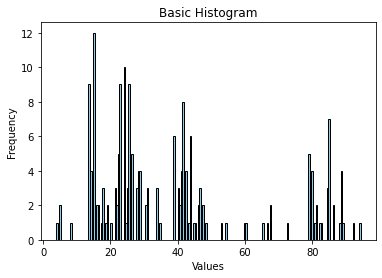

In [44]:
%matplotlib inline
plt.hist(dilution, bins=len(dilution), color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Basic Histogram')
plt.show()

In [39]:

average_dilution = np.mean(dilution)
print("Average dilution:", average_dilution)


Average dilution: 39.25804304266596


In [40]:
print(dilution)

[41.69587261909366, 82.57887429945887, 84.93493380484198, 79.9820409371122, 22.852047809595188, 28.71342056347144, 14.03364688476898, 38.72388107111186, 31.034038724032648, 15.156260155473056, 13.70847927534437, 24.03178771667947, 34.7244428333806, 14.03364688476898, 22.852047809595188, 46.52327074492757, 46.12037145304983, 60.46054844537612, 22.486899066643744, 38.72388107111186, 81.2778460299761, 22.852047809595188, 40.55496205416871, 31.251127828707116, 43.989155326093396, 47.370936242009584, 28.103936238638642, 13.70847927534437, 21.73327400634023, 46.52327074492757, 24.177589229908612, 14.03364688476898, 22.852047809595188, 40.183303825565176, 43.86416003005285, 84.93493380484198, 18.28977427498124, 16.028535837393683, 80.94221660261576, 46.62074398679895, 22.781928963648937, 13.70847927534437, 25.789947358879513, 3.868848409224116, 79.62258783327785, 47.65328726292202, 21.258300924192152, 86.28872411612181, 38.72388107111186, 26.59158685690146, 40.4047860169575, 88.75123483747765